In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
df  = pd.read_csv('dataset/pre_process_all_news_days.csv', encoding = "ISO-8859-1", parse_dates=["Date"])

In [3]:
#Get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

In [4]:
for col in tqdm(cols):
    df[col] = df[col].apply(lambda x: literal_eval(x))

100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score

def Evaluation (Method,Comment,Actual, Predicted,Scores):
    ROC_AUC=roc_auc_score(Actual,Predicted)    
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)    
    Scores[Comment] = {'Method':Method,'ROC_AUC':ROC_AUC,'Accuracy':Accuracy,
                       'Precision':Precision,'Recall':Recall,'F1':F1} 

In [6]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
xg_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [7]:
def headlines_analyze(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for cl in cols:    
        df_h['news'] = df[cl]
        train = df_h[df_h['Date']<'20141231']
        test = df_h[df_h['Date']>'20141231']
        
        y_train = train[lbl]
        y_test = test[lbl]

        xg_pipeline.fit(train['news'],y_train)
        predictions = xg_pipeline.predict(test['news'])    
        Evaluation ('XGBClassifier()',cl+'_'+lbl,y_test, predictions,sc)

In [8]:
sc={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze(lbl,sc)

In [9]:
df_sc = pd.DataFrame.from_dict(sc, orient='index')
df_sc.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top23_Label_4day,XGBClassifier(),0.563288,0.579365,0.585859,0.329545,0.421818
Top9_Label_5day,XGBClassifier(),0.559701,0.574074,0.578431,0.333333,0.422939
Top19_Label_3day,XGBClassifier(),0.557889,0.571429,0.570093,0.344633,0.429577
Top25_Label,XGBClassifier(),0.545867,0.547619,0.545455,0.656250,0.595745
Top19_Label_2day,XGBClassifier(),0.545639,0.560847,0.519685,0.385965,0.442953
Top13_Label_5day,XGBClassifier(),0.544776,0.558201,0.546296,0.333333,0.414035
Top1_Label_3day,XGBClassifier(),0.540939,0.555556,0.544554,0.310734,0.395683
Top25_Label_1day,XGBClassifier(),0.537886,0.539683,0.541096,0.424731,0.475904
Top25_Label_2day,XGBClassifier(),0.536868,0.552910,0.508065,0.368421,0.427119
Top2_Label,XGBClassifier(),0.534778,0.537037,0.534979,0.677083,0.597701


In [10]:
def headlines_analyze_two(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            cls = col1+'+'+col2             
            df_h['news'] = df[col1]+ df[col2]
            train = df_h[df_h['Date']<'20141231']
            test = df_h[df_h['Date']>'20141231']
            y_train = train[lbl]
            y_test = test[lbl]
            xg_pipeline.fit(train['news'],y_train)
            predictions = xg_pipeline.predict(test['news'])                
            Evaluation ('XGBClassifier()',cls+'_'+lbl,y_test, predictions,sc)

In [11]:
sc_2c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_two(lbl,sc_2c)

100%|██████████| 25/25 [07:26<00:00, 17.87s/it]


In [12]:
df_sc2 = pd.DataFrame.from_dict(sc_2c, orient='index')
df_sc2.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc2.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top11+Top12_Label_2day,XGBClassifier(),0.585939,0.600529,0.578125,0.432749,0.494983
Top1+Top22_Label_1day,XGBClassifier(),0.577705,0.579365,0.590604,0.473118,0.525373
Top12+Top22_Label_1day,XGBClassifier(),0.572413,0.574074,0.583893,0.467742,0.519403
Top23+Top24_Label_4day,XGBClassifier(),0.572260,0.584656,0.579832,0.392045,0.467797
Top10+Top23_Label,XGBClassifier(),0.566952,0.568783,0.562232,0.682292,0.616471
Top13+Top14_Label_5day,XGBClassifier(),0.566237,0.576720,0.568000,0.401130,0.470199
Top4+Top16_Label_2day,XGBClassifier(),0.564709,0.576720,0.539568,0.438596,0.483871
Top1+Top22_Label,XGBClassifier(),0.564348,0.566138,0.560345,0.677083,0.613208
Top10+Top12_Label_1day,XGBClassifier(),0.563676,0.566138,0.584615,0.408602,0.481013
Top18+Top20_Label_3day,XGBClassifier(),0.562737,0.574074,0.566667,0.384181,0.457912


In [13]:
def headlines_analyze_three(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            for k in range(j+1,26):
                col3 = ("Top{}".format(k))
                cls = col1+'+'+col2+'+'+col3
                df_h['news'] = df[col1]+ df[col2]+ df[col3]
                train = df_h[df_h['Date']<'20141231']
                test = df_h[df_h['Date']>'20141231']
                y_train = train[lbl]
                y_test = test[lbl]
                xg_pipeline.fit(train['news'],y_train)
                predictions = xg_pipeline.predict(test['news'])                
                Evaluation ('XGBClassifier()',cls+'_'+lbl,y_test, predictions,sc)

In [ ]:
sc_3c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_three(lbl,sc_3c)

 40%|████      | 10/25 [1:17:30<1:30:45, 363.04s/it]

In [16]:
df_sc3 = pd.DataFrame.from_dict(sc_3c, orient='index')
df_sc3.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc3.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top8+Top20+Top23_Label_1day,XGBClassifier(),0.594086,0.595238,0.602484,0.521505,0.559078
Top5+Top19+Top20_Label_3day,XGBClassifier(),0.591534,0.597884,0.583893,0.491525,0.533742
Top8+Top9+Top23_Label,XGBClassifier(),0.588374,0.589947,0.581498,0.687500,0.630072
Top12+Top17+Top18_Label_1day,XGBClassifier(),0.587366,0.589947,0.622047,0.424731,0.504792
Top6+Top9+Top25_Label,XGBClassifier(),0.583417,0.584656,0.579909,0.661458,0.618005
Top3+Top6+Top11_Label_2day,XGBClassifier(),0.582888,0.600529,0.586207,0.397661,0.473868
Top8+Top20+Top23_Label,XGBClassifier(),0.580561,0.582011,0.575893,0.671875,0.620192
Top4+Top9+Top11_Label_2day,XGBClassifier(),0.580473,0.597884,0.581197,0.397661,0.472222
Top13+Top23+Top25_Label_1day,XGBClassifier(),0.580393,0.582011,0.593333,0.478495,0.529762
Top6+Top13+Top16_Label_2day,XGBClassifier(),0.578947,0.597884,0.585586,0.380117,0.460993


In [21]:
def analyze_all_news(lbl):
    df_h = df[['Date',lbl]].copy()
    df_h['news'] = df['news_stemmed']
    train = df_h[df_h['Date']<'20141231']
    test = df_h[df_h['Date']>'20141231']
    y_train = train[lbl]
    y_test = test[lbl]
    xg_pipeline.fit(train['news'],y_train)
    predictions = xg_pipeline.predict(test['news'])                
    Evaluation ('XGBClassifier()','news_stemmed'+lbl,y_test, predictions,sc_news)

In [22]:
sc_news={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    analyze_all_news(lbl)

In [23]:
df_sc_news = pd.DataFrame.from_dict(sc_news, orient='index')
df_sc_news.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc_news

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
news_stemmedLabel_3day,XGBClassifier(),0.535500,0.547619,0.525862,0.344633,0.416382
news_stemmedLabel_1day,XGBClassifier(),0.532426,0.534392,0.535211,0.408602,0.463415
news_stemmedLabel_4day,XGBClassifier(),0.517721,0.529101,0.492063,0.352273,0.410596
news_stemmedLabel_2day,XGBClassifier(),0.483982,0.500000,0.428571,0.315789,0.363636
news_stemmedLabel,XGBClassifier(),0.479671,0.481481,0.491379,0.593750,0.537736
news_stemmedLabel_5day,XGBClassifier(),0.462602,0.476190,0.403670,0.248588,0.307692


# Parameters Tuning

## One Headline

In [46]:
xg_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier()) ])

In [87]:
params = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'vect__max_features': (100,10000),                    
          'clf__max_depth': (4, 6, 8),
          'clf__min_child_weight': (4, 8, 13)}   

In [88]:
df_h = df[['Date','Label_1day','Top25']].copy()   
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_1day']
y_test = test['Label_1day']

In [89]:
gs = GridSearchCV(estimator=xg_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['Top25'], y_train)

In [90]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__max_depth': 6, 'clf__min_child_weight': 4, 'vect__max_features': 100, 'vect__ngram_range': (1, 1)}
accuracy: 0.5577648358702764


In [97]:
xg_pipe = Pipeline([    
    ('vect', CountVectorizer(min_df=1,ngram_range=(1,1),analyzer=lambda x: x )),  #min_df=5, max_features=10000, 
    ('tfidf', TfidfTransformer(use_idf=True)),  #, norm='l2'  use_idf=False
    ('clf', XGBClassifier(#max_depth=6,
                          #min_child_weight= 4                                   
                          )) ])

In [98]:
xg_pipe.fit(train['Top25'],y_train)
prediction = xg_pipe.predict(test['Top25'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.55      0.72      0.62       192
           1       0.58      0.40      0.47       186

    accuracy                           0.56       378
   macro avg       0.57      0.56      0.55       378
weighted avg       0.56      0.56      0.55       378

Accuracy: 0.5608465608465608


Text(0.5, 15.0, 'Predicted')

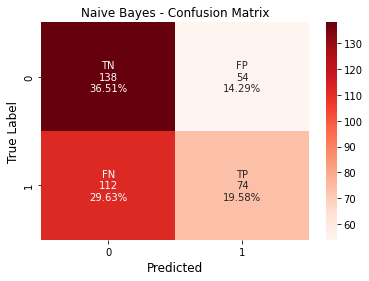

In [99]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('XGBoost - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted Values',fontsize=12)
plt.show()

## Two Headlines

In [100]:
xg_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier()) ])

In [101]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'vect__max_features': (10000,15000),                    
          'clf__max_depth': (4, 6, 8),
          'clf__min_child_weight': (4, 8, 13)}          

In [102]:
df_h = df[['Date','Label_2day','Top6','Top16']].copy()   
df_h['news'] = df_h['Top6']+df_h['Top16']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_2day']
y_test = test['Label_2day']

In [103]:
gs = GridSearchCV(estimator=xg_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [104]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__max_depth': 6, 'clf__min_child_weight': 13, 'vect__max_features': 10000, 'vect__ngram_range': (1, 1)}
accuracy: 0.5366406182487069


In [119]:
xg_pipe = Pipeline([    
    ('vect', CountVectorizer(min_df=5, max_features=10000, ngram_range=(1,1), analyzer=lambda x: x )),  #min_df=5, max_features=10000,ngram_range=(1,2), 
    ('tfidf', TfidfTransformer(use_idf=True)),  #, norm='l2'  use_idf=False
    ('clf', XGBClassifier(max_depth=6,
                          min_child_weight= 13                                  
                          )) ])

In [120]:
xg_pipeline.fit(train['news'],y_train)
prediction = xg_pipeline.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.61      0.73      0.67       207
           1       0.58      0.44      0.50       171

    accuracy                           0.60       378
   macro avg       0.59      0.59      0.58       378
weighted avg       0.60      0.60      0.59       378

Accuracy: 0.6005291005291006


Text(0.5, 15.0, 'Predicted')

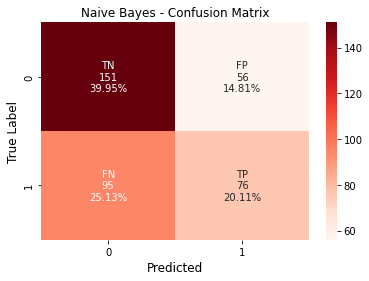

In [121]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('XGBoost - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Three Headlines 

In [122]:
xg_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier()) ])

In [164]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'vect__max_features': (1,10),                    
          'clf__max_depth': (2, 4),
          'clf__min_child_weight': (2,4),
          'clf__gamma':(4,5),
          'clf__reg_alpha':(10,15),
          'clf__reg_lambda':(0.5,1)}   

In [165]:
df_h = df[['Date','Label_4day','Top1','Top6','Top23']].copy()   
df_h['news'] = df_h['Top1']+df_h['Top6']+df_h['Top23']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_4day']
y_test = test['Label_4day']

In [166]:
gs = GridSearchCV(estimator=xg_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [167]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__gamma': 4, 'clf__max_depth': 2, 'clf__min_child_weight': 2, 'clf__reg_alpha': 10, 'clf__reg_lambda': 0.5, 'vect__max_features': 1, 'vect__ngram_range': (1, 1)}
accuracy: 0.5770187523918867


In [168]:
xg_pipe = Pipeline([    
    ('vect', CountVectorizer(max_features=10,ngram_range=(1,1), analyzer=lambda x: x )),  #min_df=5, max_features=10000,ngram_range=(1,1), 
    ('tfidf', TfidfTransformer(use_idf=False)),  #, norm='l2'  use_idf=False
    ('clf', XGBClassifier(max_depth=2,
                          min_child_wight=2,
                          reg_lambda=0.5,
                          reg_alpha=10,
                          gamma=4
                          )) ])

In [169]:
xg_pipeline.fit(train['news'],y_train)
prediction = xg_pipeline.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       202
           1       0.62      0.44      0.52       176

    accuracy                           0.62       378
   macro avg       0.62      0.61      0.60       378
weighted avg       0.62      0.62      0.61       378

Accuracy: 0.6164021164021164


Text(0.5, 15.0, 'Predicted')

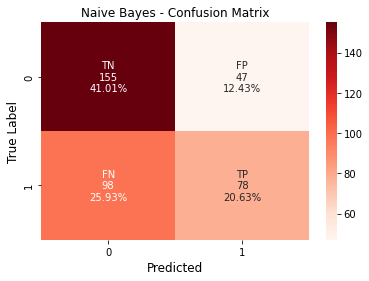

In [170]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('XGBoost - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

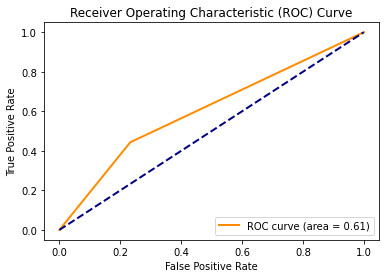

In [171]:
# y_test contains the true labels for the test set, y_pred contains the predicted labels or probabilities
fpr, tpr, thresholds = roc_curve(y_test,prediction)

# calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()